### Edgar Moises Hernandez-Gonzalez
#### 05/03/20-21/04/20
#### Clasificacion de imagenes motoras en EEG con CNN-2D
##### Caracteristicas = Escalogramas CWT (3D)
##### Concatenacion vertical
##### Resize proporcional de 352x125
##### 5 ejecuciones independientes

#### CNN-2D
##### Sujeto 1
##### Accuracy = 53.47%
##### Kappa = 0.3796

In [1]:
from google.colab import drive

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import cohen_kappa_score, confusion_matrix
import pywt
import cv2
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout
from keras.optimizers import Adam
#from keras.callbacks import ModelCheckpoint
from keras import backend as K

Using TensorFlow backend.


In [ ]:
# para que este script funcione debe de decir 'channels_last', si dice 'channels_first' no sirve
K.image_data_format()

'channels_last'

In [ ]:
x_train = pd.read_csv("/content/drive/My Drive/BCI-IV-2a/RAW/MI-EEG-A01T.csv", header=None)
x_test = pd.read_csv("/content/drive/My Drive/BCI-IV-2a/RAW/MI-EEG-A01E.csv", header=None)
y_train = pd.read_csv("/content/drive/My Drive/BCI-IV-2a/RAW/EtiquetasA01T.csv", header=None)
y_test = pd.read_csv("/content/drive/My Drive/BCI-IV-2a/RAW/EtiquetasA01E.csv", header=None)

In [ ]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(288, 22000)
(288, 22000)
(288, 1)
(288, 1)


In [ ]:
n_samples_train = len(y_train)
n_samples_test = len(y_test) #en caso de no tener el y_test se puede utilizar el x_test

print("n_samples_train:", n_samples_train)
print("n_samples_test :", n_samples_test)

n_samples_train: 288
n_samples_test : 288


In [ ]:
n_classes = len(np.unique(y_test)) #esto se podria calcular asi n_clases = len(np.unique(y)), la y puede ser train o test

print("n_classes:", n_classes)

n_classes: 4


In [ ]:
#codificar etiquetas con valores de 0 a nClases-1
le = LabelEncoder().fit(y_train)
y_train = le.transform(y_train)
y_test = le.transform(y_test)

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
#unir 22 canales
def unir_escalogramas_vertical_resize(data):
  escalas = np.arange(1,129)
  dim = (125, 352) #ancho, alto
  datos = np.zeros((288,352,125))
  temporal = np.zeros((2816,1000))
  for i in range(data.shape[0]): #288 muestras
    for j in range(22): #22 canales
      sig = data.iloc[i, j*1000:(j+1)*1000]
      coef, freqs = pywt.cwt(sig, escalas, 'cmor3-3') #escalograma CWT
      temporal[j*128:(j+1)*128, :] = abs(coef)
    resized = cv2.resize(temporal, dim, interpolation=cv2.INTER_AREA)
    datos[i] = resized
    if i % 100 == 0: #esto solo es para ver como avanza
      print(i)
  return datos

In [ ]:
#llamar a escalogramas(data)
#primero x_train para no acabarse la RAM
x_train = unir_escalogramas_vertical_resize(x_train)

0
100
200


In [ ]:
#llamar a escalogramas(data)
#despues x_test para no acabarse la RAM
x_test = unir_escalogramas_vertical_resize(x_test)

0
100
200


In [ ]:
print(x_train.shape)
print(x_test.shape)

(288, 352, 125)
(288, 352, 125)


In [ ]:
print(np.max(x_train))
print(np.max(x_test))
print(np.min(x_train))
print(np.min(x_test))
print(np.mean(x_train))
print(np.mean(x_test))

60.73229321054336
55.30505307271394
0.0016808164126656904
0.0014808908865048041
3.8612015488227627
3.76365981914927


In [ ]:
#convertir a float
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

#escalar los valores en un rango de 0 a 1 (normalizar)
x_train /= 61.0
x_test /= 61.0

In [ ]:
print(np.max(x_train))
print(np.max(x_test))
print(np.min(x_train))
print(np.min(x_test))
print(np.mean(x_train))
print(np.mean(x_test))

0.99561137
0.90664023
2.7554368e-05
2.42769e-05
0.06329843
0.061699342


In [ ]:
#convertir de 3D a 4D
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], x_train.shape[2], 1))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], x_test.shape[2], 1))

print(x_train.shape)
print(x_test.shape)

(288, 352, 125, 1)
(288, 352, 125, 1)


In [ ]:
# usa el .hdf5
# mc = ModelCheckpoint('best.h5', monitor='val_accuracy', save_best_only=True)
#mc = ModelCheckpoint('/content/drive/My Drive/BCI-IV-2a/Modelos/Mejor_modelo_CWT01.hdf5',
#monitor='val_accuracy', save_best_only=True)

In [ ]:
def CNN_2D():
  model = Sequential()
  model.add(Conv2D(8, (3,3), activation='relu', input_shape=x_train.shape[1:]))
  model.add(MaxPool2D((2,2)))
  model.add(Conv2D(8, (3,3), activation='relu'))
  model.add(MaxPool2D((2,2)))
  model.add(Conv2D(8, (3,3), activation='relu'))
  model.add(MaxPool2D((2,2)))
  model.add(Flatten())
  model.add(Dense(32, activation='relu'))
  model.add(Dropout(0.2))
  model.add(Dense(n_classes, activation='softmax'))

  optimizer = Adam(lr=1e-4)
  model.compile(optimizer = optimizer,
                loss = 'sparse_categorical_crossentropy',
                metrics = ['accuracy'])
  return model

In [ ]:
'''def CNN_2D_BN():
  model = Sequential()
  model.add(Conv2D(8, (3,3), input_shape=x_train.shape[1:]))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(MaxPool2D((2,2)))
  model.add(Conv2D(8, (3,3)))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(MaxPool2D((2,2)))
  model.add(Conv2D(8, (3,3)))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(MaxPool2D((2,2)))
  model.add(Flatten())
  model.add(Dense(128))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Dense(n_classes, activation='softmax'))

  optimizer = Adam(lr=1e-5)
  model.compile(optimizer = optimizer,
                loss = 'sparse_categorical_crossentropy',
                metrics = ['accuracy'])
  return model'''

"def CNN_2D_BN():\n  model = Sequential()\n  model.add(Conv2D(8, (3,3), input_shape=x_train.shape[1:]))\n  model.add(BatchNormalization())\n  model.add(Activation('relu'))\n  model.add(MaxPool2D((2,2)))\n  model.add(Conv2D(8, (3,3)))\n  model.add(BatchNormalization())\n  model.add(Activation('relu'))\n  model.add(MaxPool2D((2,2)))\n  model.add(Conv2D(8, (3,3)))\n  model.add(BatchNormalization())\n  model.add(Activation('relu'))\n  model.add(MaxPool2D((2,2)))\n  model.add(Flatten())\n  model.add(Dense(128))\n  model.add(BatchNormalization())\n  model.add(Activation('relu'))\n  model.add(Dense(n_classes, activation='softmax'))\n\n  optimizer = Adam(lr=1e-5)\n  model.compile(optimizer = optimizer,\n                loss = 'sparse_categorical_crossentropy',\n                metrics = ['accuracy'])\n  return model"

Iteration: 1
loss:  3.886421892378065
accuracy:  0.53125
kappa:  0.375
confusion matrix:
 [[34 25  3 10]
 [23 39  9  1]
 [ 3  3 38 28]
 [ 2  1 27 42]]


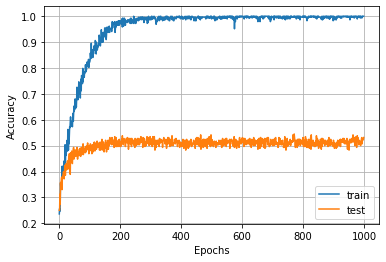

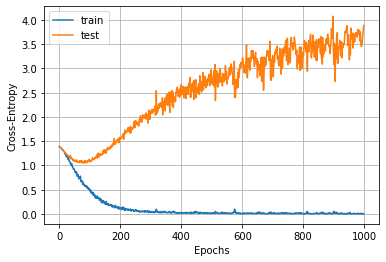

Iteration: 2
loss:  3.854615052541097
accuracy:  0.4722222089767456
kappa:  0.2962962962962963
confusion matrix:
 [[43 13  6 10]
 [31 32  7  2]
 [12  6 25 29]
 [ 7  0 29 36]]


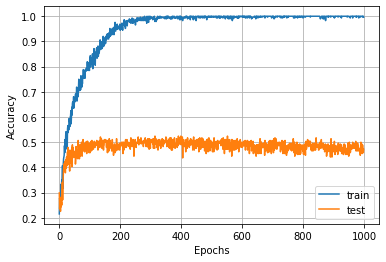

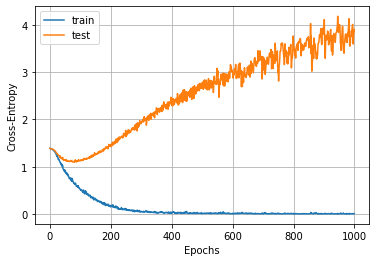

Iteration: 3
loss:  3.726598766114977
accuracy:  0.5208333134651184
kappa:  0.36111111111111116
confusion matrix:
 [[39 21  4  8]
 [24 37 10  1]
 [ 8  4 31 29]
 [ 5  0 24 43]]


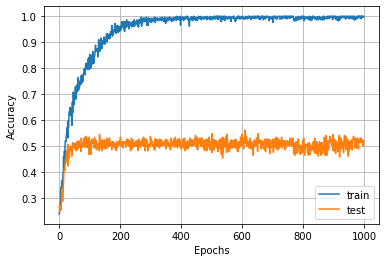

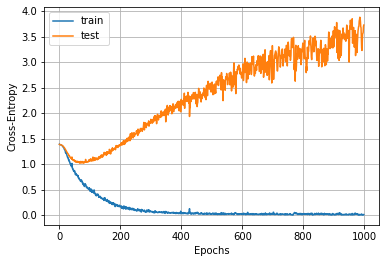

Iteration: 4
loss:  3.625377999411689
accuracy:  0.4895833432674408
kappa:  0.3194444444444444
confusion matrix:
 [[36 28  4  4]
 [28 38  6  0]
 [ 9  7 29 27]
 [ 9  2 23 38]]


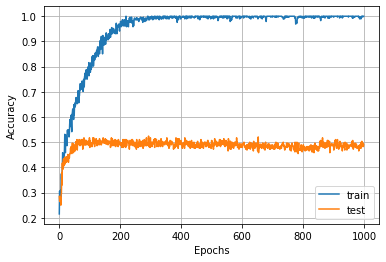

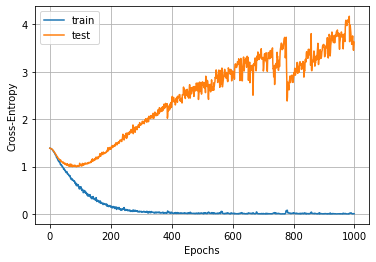

Iteration: 5
loss:  4.570073498619927
accuracy:  0.4756944477558136
kappa:  0.30092592592592593
confusion matrix:
 [[35 16  7 14]
 [24 37  9  2]
 [ 7  5 27 33]
 [ 4  0 30 38]]


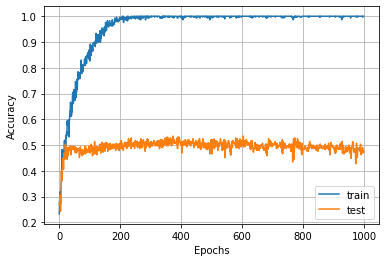

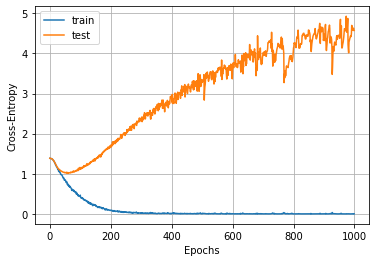


Resultados:
loss: [3.886421892378065, 3.854615052541097, 3.726598766114977, 3.625377999411689, 4.570073498619927]
accuracy: [0.53125, 0.4722222089767456, 0.5208333134651184, 0.4895833432674408, 0.4756944477558136]
kappa: [0.375, 0.2962962962962963, 0.36111111111111116, 0.3194444444444444, 0.30092592592592593]


In [ ]:
array_loss = []
array_acc = []
array_kappa = []
for i in range(5):
  print("Iteration:", i+1)
    
  model = CNN_2D()

  history = model.fit(x_train, y_train, epochs=1000, batch_size=18,
                      validation_data=(x_test, y_test), verbose=0)
                      # callbacks=[mc]
    
  test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)
  array_loss.append(test_loss)
  print("loss: ", test_loss)
  array_acc.append(test_acc)
  print("accuracy: ", test_acc)
    
  probabilidades = model.predict(x_test)
  y_pred = np.argmax(probabilidades, 1) #1=fila
    
  kappa = cohen_kappa_score(y_test, y_pred)
  array_kappa.append(kappa)
  print("kappa: ", kappa)
    
  matriz_confusion = confusion_matrix(y_test, y_pred)
  print("confusion matrix:\n", matriz_confusion)
    
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.grid()
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend(['train', 'test'])
  plt.show()
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.grid()
  plt.xlabel('Epochs')
  plt.ylabel('Cross-Entropy')
  plt.legend(['train', 'test'])
  plt.show()
    
print() 
print("Resultados:")
print("loss:", array_loss)
print("accuracy:", array_acc)
print("kappa:", array_kappa)

In [ ]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 352, 125, 8)       80        
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 176, 62, 8)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 176, 62, 8)        584       
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 88, 31, 8)         0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 88, 31, 8)         584       
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 44, 15, 8)         0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 5280)             

In [ ]:
print("Mean Accuracy: %.4f" % np.mean(array_acc))
print("std: (+/- %.4f)" % np.std(array_acc))
print("Mean Kappa: %.4f" % np.mean(array_kappa))
print("std: (+/- %.4f)" % np.std(array_kappa))
print("Max Accuracy: %.4f" % np.max(array_acc))
print("Max Kappa: %.4f" % np.max(array_kappa))

Mean Accuracy: 0.4979
std: (+/- 0.0239)
Mean Kappa: 0.3306
std: (+/- 0.0319)
Max Accuracy: 0.5312
Max Kappa: 0.3750
